# Introduction

This notebook has code for:

1. The majority class classifier baseline.
2. Using grid search to find the best hyperparameters for the BERT model.
3. Using the best BERT model on the test set.






# Imports

In [1]:
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15

!pip install pydot --quiet
!pip install transformers==4.17 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatibl

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install transformers torch --quiet

In [5]:
# Load baseline tokenizer and model
from transformers import BertTokenizer, TFBertModel

checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Data

Split into train, validation, and test sets. Turn data into tf tensors. Get max_sequence_length for tokenization in next step

In [6]:
# Get Dataset
gw_sentences_df = pd.read_csv('/content/drive/MyDrive/w266/Final Project/GWStance GWSD.csv', sep='\t')
gw_sentences_df = gw_sentences_df[5:] # remove first five rows; they're screen sentences we use to make sure that annotators correctly understand the task.
gw_sentences_df.head()

,Unnamed: 0,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test
5,5,1,0,t0,Warmer-than-normal sea surface temperatures ar...,neutral,neutral,neutral,agrees,agrees,agrees,agrees,agrees,0.003105,0.711260,0.285634,1_0_t0,False
6,6,1,0,t1,We will continue to rely in part on fossil fue...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000830,0.001163,0.998006,1_0_t1,False
7,7,1,0,t10,The actual rise in sea levels measured only 1....,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000802,0.001174,0.998023,1_0_t10,False
8,8,1,0,t11,Claims of global warming have been greatly exa...,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.997695,0.001171,0.001134,1_0_t11,False
9,9,1,0,t12,The Intergovernmental Panel on Climate Change ...,neutral,disagrees,neutral,neutral,neutral,neutral,neutral,neutral,0.031351,0.002962,0.965687,1_0_t12,False


In [7]:
# Drop irrelevant columns, split into test and train
gwsd = gw_sentences_df[['sentence', 'agree', 'disagree', 'neutral', 'in_held_out_test']]

# Make fxn to categorize sentiment
def categorize_sentiment(agree, disagree, neutral):
    if disagree > agree and disagree > neutral:
        return 1
    elif neutral > agree and neutral > disagree:
        return 0
    else:
        return 2

# Apply fxn to make 0, 1, 2 for
gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)
gwsd.head()

<ipython-input-7-b17ddf060ae2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwsd['sentiment'] = gwsd.apply(lambda row: categorize_sentiment(row['agree'], row['disagree'], row['neutral']), axis=1)


,sentence,agree,disagree,neutral,in_held_out_test,sentiment
5,Warmer-than-normal sea surface temperatures ar...,0.711260,0.003105,0.285634,False,2
6,We will continue to rely in part on fossil fue...,0.001163,0.000830,0.998006,False,0
7,The actual rise in sea levels measured only 1....,0.001174,0.000802,0.998023,False,0
8,Claims of global warming have been greatly exa...,0.001171,0.997695,0.001134,False,1
9,The Intergovernmental Panel on Climate Change ...,0.002962,0.031351,0.965687,False,0


In [8]:
# Split into train and test sets

train_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 0]
test_sentences = gwsd['sentence'][gwsd['in_held_out_test'] == 1]

print("Train and test sentence shapes:", train_sentences.shape, test_sentences.shape)

train_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 0]
train_sentiment = tf.convert_to_tensor(train_sentiment, dtype=tf.int32)
test_sentiment = gwsd['sentiment'][gwsd['in_held_out_test'] == 1]
test_sentiment = tf.convert_to_tensor(test_sentiment, dtype=tf.int32)

print("Train and test sentiment shapes:",train_sentiment.shape, test_sentiment.shape)

# Turn into TF Tensors
train_sentences = tf.convert_to_tensor(train_sentences.values, dtype=tf.string)
test_sentences = tf.convert_to_tensor(test_sentences.values, dtype=tf.string)


Train and test sentence shapes: (2095,) (200,)
Train and test sentiment shapes: (2095,) (200,)


In [12]:
# Look at class imbalance
train_sentiment_counts = np.unique(train_sentiment, return_counts=True)
train_sentiment_counts

(array([0, 1, 2], dtype=int32), array([788, 361, 946]))

# Majority Class Baseline

See the test accuracy of a majority class classifier.

In [ ]:
train_sentiment_counts = np.unique(train_sentiment, return_counts=True)
train_sentiment_counts

(array([0, 1, 2], dtype=int32), array([788, 361, 946]))

Because 0 is neutral, 1 is disagree, 2 is agree, agree is the most common.


In [ ]:
# Get test accuracy if model only answers agree.

y_pred = [2] * len(test_sentiment)

# Compute the number of correct predictions
correct_predictions = sum([1 for true, pred in zip(test_sentiment, y_pred) if true == pred])

# Compute accuracy
accuracy = correct_predictions / len(test_sentiment)

# Print the accuracy
print(f"Majority Class Classifier Test Accuracy: {accuracy:.2f}")

Majority Class Classifier Test Accuracy: 0.38


# Baseline BERT Model

Get a baseline BERT model

In [ ]:
# Get MAX_SEQUENCE_LENGTH
MAX_SEQUENCE_LENGTH = 265 # from paper


print("Max UTF-8 sequence length:", MAX_SEQUENCE_LENGTH)

# Encode and Tokenize train and test sets
train_sentences = [x.decode('utf-8') for x in train_sentences.numpy()]
test_sentences = [x.decode('utf-8') for x in test_sentences.numpy()]

x_train = bert_tokenizer(train_sentences,
                         max_length=MAX_SEQUENCE_LENGTH,
                         truncation=True,
                         padding='max_length',
                         return_tensors='tf')
x_test = bert_tokenizer(test_sentences,
                        max_length=MAX_SEQUENCE_LENGTH,
                        truncation=True,
                        padding='max_length',
                        return_tensors='tf')

Max UTF-8 sequence length: 265


In [ ]:
# define the baseline bert model

def create_bert_multiclass_model(checkpoint = checkpoint,
                                 num_classes = 3,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 pooler=True):
    """
    Build a simple classification model with BERT. Use the Pooler Output or CLS token for classification purposes.
    """

    # get a BERT model with input checkpoint and make fully traininable
    bert_model = TFBertModel.from_pretrained(checkpoint, from_pt=True) # fresh instance of model
    bert_model.trainable = True

    # make input layers
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask_layer')

    # BERT
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(input_ids=bert_inputs['input_ids'],
                         token_type_ids=bert_inputs['token_type_ids'],
                         attention_mask=bert_inputs['attention_mask'])

    # get pooler and cls token
    if pooler:
      token = bert_out[1] #pooler token
    else:
      token = bert_out[0][:, 0, :] #CLS token

    # HIDDEN LAYER
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(token)

    # DROPOUT
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # CLASSIFICATION
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')


    ### END YOUR CODE
    return classification_model

# Hyperparameter Tuning

## Test out Model on Random Parameters

In [ ]:
pooler_bert_model = create_bert_multiclass_model()
pooler_bert_model.summary()

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, 347)]                0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, 347)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 347)]                0         []                            
 tLayer)                                                                                      

In [ ]:
pooler_bert_model_history = pooler_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                                                  train_sentiment,
                                                  validation_split=0.1, # split 10% of data for validation
                                                  batch_size=8,
                                                  epochs=1)

236/236 [==============================] - 193s 638ms/step - loss: 0.9559 - accuracy: 0.5448 - val_loss: 0.9022 - val_accuracy: 0.6048


In [ ]:
# score baseline
baseline_score = pooler_bert_model.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                                                  test_sentiment)

print('Test loss:', baseline_score[0])
print('Test accuracy:', baseline_score[1])

7/7 [==============================] - 5s 735ms/step - loss: 0.8432 - accuracy: 0.6350
Test loss: 0.8432060480117798
Test accuracy: 0.6349999904632568


In [ ]:
# Export results for further analysis

predictions = pooler_bert_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])

# Get highest probability
predicted_labels = predictions.argmax(axis=1)

# Create a DataFrame for x_test, actual labels, and predicted labels
x_test_df = pd.DataFrame(x_test.input_ids)

# Combine the actual labels (test_sentiment) and predicted labels
results_df = pd.DataFrame({
    "x_test": x_test_df.apply(lambda row: row.tolist(), axis=1),  # Converts rows to lists
    "actual_label": test_sentiment,
    "predicted_label": predicted_labels
})

# Decode x_test column using bert_tokenizer
results_df["x_test"] = results_df["x_test"].apply(lambda x: bert_tokenizer.decode(x, skip_special_tokens=True))

results_df

7/7 [==============================] - 8s 736ms/step


,x_test,actual_label,predicted_label
0,Evidence now leans against global warming resu...,1,0
1,45 % of the general public view perceived glob...,0,0
2,There is a danger that we can get used to glob...,2,2
3,Global warming isn ’ t happening.,1,1
4,Humans have a role and therefore as a matter o...,2,0
...,...,...,...
195,Climate change could cause the next financial ...,2,2
196,The things we do to reduce greenhouse gas poll...,2,2
197,American diplomacy can convince the communist ...,1,0
198,Many young adults have become anxious about wh...,0,0


In [ ]:
# Looks good, let's export the results

#results_df.to_csv('/content/drive/MyDrive/w266/Final Project/meral_results/BERT_baseline_results.csv', index=False)

## BERT Baseline Grid Search

Use grid search to hyperparameter tune our baseline BERT model.

In [ ]:
import itertools
import numpy as np
from sklearn.model_selection import train_test_split

# Define parameter grid
dropout_values = [0.2, 0.3, 0.4, 0.5]
learning_rate_values = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005]
pooler_values = [True, False]

param_grid = list(itertools.product(dropout_values, learning_rate_values, pooler_values))

# Results storage
results = []

# Perform Grid Search
for dropout, learning_rate, pooler in param_grid:
    print(f"Training with dropout={dropout}, learning_rate={learning_rate}, pooler={pooler}")

    # Create model
    model = create_bert_multiclass_model(
        checkpoint=checkpoint,  # Adjust if needed
        num_classes=3,
        hidden_size=201,
        dropout=dropout,
        learning_rate=learning_rate,
        pooler=pooler
    )

    # Train model
    history = model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                        train_sentiment,
                        validation_split=0.1, # split 10% of data for validation
                        batch_size=8,
                        epochs=1)

    # Record results
    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'dropout': dropout,
        'learning_rate': learning_rate,
        'pooler': pooler,
        'val_accuracy': val_acc
    })

Training with dropout=0.2, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 191s 653ms/step - loss: 0.9243 - accuracy: 0.5841 - val_loss: 0.8567 - val_accuracy: 0.6095
Training with dropout=0.2, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 192s 651ms/step - loss: 0.8553 - accuracy: 0.5958 - val_loss: 0.7465 - val_accuracy: 0.6381
Training with dropout=0.2, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 192s 651ms/step - loss: 0.8861 - accuracy: 0.5989 - val_loss: 0.7944 - val_accuracy: 0.6524
Training with dropout=0.2, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 191s 651ms/step - loss: 0.8532 - accuracy: 0.6058 - val_loss: 0.8112 - val_accuracy: 0.5952
Training with dropout=0.2, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 190s 651ms/step - loss: 0.9059 - accuracy: 0.5772 - val_loss: 0.7795 - val_accuracy: 0.6190
Training with dropout=0.2, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 191s 654ms/step - loss: 0.8553 - accuracy: 0.6117 - val_loss: 0.7252 - val_accuracy: 0.6714
Training with dropout=0.2, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 198s 652ms/step - loss: 0.8780 - accuracy: 0.5984 - val_loss: 0.8574 - val_accuracy: 0.5714
Training with dropout=0.2, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 196s 654ms/step - loss: 0.8774 - accuracy: 0.5963 - val_loss: 0.8781 - val_accuracy: 0.5952
Training with dropout=0.2, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 198s 653ms/step - loss: 0.9091 - accuracy: 0.5920 - val_loss: 0.8529 - val_accuracy: 0.6048
Training with dropout=0.2, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 194s 652ms/step - loss: 0.9303 - accuracy: 0.5671 - val_loss: 0.8391 - val_accuracy: 0.6190
Training with dropout=0.3, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 653ms/step - loss: 0.9998 - accuracy: 0.5395 - val_loss: 0.8323 - val_accuracy: 0.5905
Training with dropout=0.3, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 197s 653ms/step - loss: 0.9279 - accuracy: 0.5565 - val_loss: 0.8721 - val_accuracy: 0.5857
Training with dropout=0.3, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 655ms/step - loss: 0.9028 - accuracy: 0.5761 - val_loss: 0.8558 - val_accuracy: 0.6048
Training with dropout=0.3, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 196s 653ms/step - loss: 0.9059 - accuracy: 0.5671 - val_loss: 0.8383 - val_accuracy: 0.5857
Training with dropout=0.3, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 201s 655ms/step - loss: 0.8794 - accuracy: 0.6048 - val_loss: 0.9010 - val_accuracy: 0.6000
Training with dropout=0.3, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 654ms/step - loss: 0.8568 - accuracy: 0.6122 - val_loss: 0.7899 - val_accuracy: 0.6286
Training with dropout=0.3, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 203s 656ms/step - loss: 1.0330 - accuracy: 0.4971 - val_loss: 0.8698 - val_accuracy: 0.5952
Training with dropout=0.3, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 197s 655ms/step - loss: 0.8462 - accuracy: 0.6223 - val_loss: 0.7869 - val_accuracy: 0.6571
Training with dropout=0.3, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 201s 657ms/step - loss: 0.9193 - accuracy: 0.5777 - val_loss: 0.8203 - val_accuracy: 0.6048
Training with dropout=0.3, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 655ms/step - loss: 0.8508 - accuracy: 0.6186 - val_loss: 0.7337 - val_accuracy: 0.7048
Training with dropout=0.4, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 201s 656ms/step - loss: 0.9987 - accuracy: 0.5496 - val_loss: 0.8416 - val_accuracy: 0.5952
Training with dropout=0.4, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 203s 657ms/step - loss: 0.9132 - accuracy: 0.5777 - val_loss: 0.8389 - val_accuracy: 0.5619
Training with dropout=0.4, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 198s 655ms/step - loss: 1.0075 - accuracy: 0.5332 - val_loss: 0.9607 - val_accuracy: 0.5429
Training with dropout=0.4, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 204s 656ms/step - loss: 0.8834 - accuracy: 0.6005 - val_loss: 0.8837 - val_accuracy: 0.6286
Training with dropout=0.4, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 655ms/step - loss: 1.0409 - accuracy: 0.5019 - val_loss: 0.9779 - val_accuracy: 0.5571
Training with dropout=0.4, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 669ms/step - loss: 0.8551 - accuracy: 0.6101 - val_loss: 0.8316 - val_accuracy: 0.6143
Training with dropout=0.4, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 197s 654ms/step - loss: 1.0534 - accuracy: 0.4886 - val_loss: 0.9412 - val_accuracy: 0.4952
Training with dropout=0.4, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 655ms/step - loss: 0.8546 - accuracy: 0.6090 - val_loss: 0.8278 - val_accuracy: 0.6143
Training with dropout=0.4, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 655ms/step - loss: 0.9322 - accuracy: 0.5592 - val_loss: 0.8874 - val_accuracy: 0.5857
Training with dropout=0.4, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 197s 667ms/step - loss: 0.9020 - accuracy: 0.5867 - val_loss: 0.8275 - val_accuracy: 0.6190
Training with dropout=0.5, learning_rate=1e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 195s 653ms/step - loss: 1.0473 - accuracy: 0.5008 - val_loss: 0.9137 - val_accuracy: 0.5524
Training with dropout=0.5, learning_rate=1e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 654ms/step - loss: 0.9361 - accuracy: 0.5570 - val_loss: 0.8101 - val_accuracy: 0.6048
Training with dropout=0.5, learning_rate=2e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 654ms/step - loss: 0.9999 - accuracy: 0.5135 - val_loss: 0.8823 - val_accuracy: 0.5571
Training with dropout=0.5, learning_rate=2e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 193s 652ms/step - loss: 0.9113 - accuracy: 0.5751 - val_loss: 0.8825 - val_accuracy: 0.6000
Training with dropout=0.5, learning_rate=3e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 196s 654ms/step - loss: 0.9360 - accuracy: 0.5671 - val_loss: 0.8459 - val_accuracy: 0.5905
Training with dropout=0.5, learning_rate=3e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 196s 654ms/step - loss: 0.8852 - accuracy: 0.6000 - val_loss: 0.8362 - val_accuracy: 0.6286
Training with dropout=0.5, learning_rate=4e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 200s 659ms/step - loss: 1.0848 - accuracy: 0.4721 - val_loss: 0.9863 - val_accuracy: 0.4571
Training with dropout=0.5, learning_rate=4e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 199s 671ms/step - loss: 0.9442 - accuracy: 0.5554 - val_loss: 0.9197 - val_accuracy: 0.5476
Training with dropout=0.5, learning_rate=5e-05, pooler=True


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 197s 655ms/step - loss: 1.0007 - accuracy: 0.5225 - val_loss: 0.8247 - val_accuracy: 0.6238
Training with dropout=0.5, learning_rate=5e-05, pooler=False


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 203s 656ms/step - loss: 0.9073 - accuracy: 0.5634 - val_loss: 0.8273 - val_accuracy: 0.6095


In [ ]:
# Sort results by accuracy
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Best result
best_params = sorted_results[0]
print(f"Best Parameters: {best_params}")

Best Parameters: {'dropout': 0.3, 'learning_rate': 5e-05, 'pooler': False, 'val_accuracy': 0.7047619223594666}


In [ ]:
sorted_data = pd.DataFrame(sorted_results)
sorted_data

,dropout,learning_rate,pooler,val_accuracy
0,0.3,0.00005,False,0.704762
1,0.2,0.00003,False,0.671429
2,0.3,0.00004,False,0.657143
3,0.2,0.00002,True,0.652381
4,0.2,0.00001,False,0.638095
5,0.3,0.00003,False,0.628571
6,0.4,0.00002,False,0.628571
7,0.5,0.00003,False,0.628571
8,0.5,0.00005,True,0.623810
9,0.2,0.00003,True,0.619048


In [ ]:
# export data so I can work with it in a new notebook without a GPU

sorted_data.to_csv('/content/drive/MyDrive/w266/Final Project/meral_results/hyperparameter_tuning_results_baseline.csv', index=False)

## Refined Grid Search

After narrowing down which parameters I'm interested in (see meral_gridseach_analysis.ipynb), I am going to run the two most promising hyperparameter sets x3 each, to see which produces the most stable results.

1.   dropout 0.3, learning rate = 5e-5, pooler = False
2.   dropout 0.2, learning rate 3e-5, pooler = False

**Answer: dropout 0.3, learning rate 5e-5, seed 2.**



In [ ]:
# Define the two promising hyperparameter sets
hyperparameter_sets = [
    {'dropout': 0.3, 'learning_rate': 5e-5, 'pooler': False},
    {'dropout': 0.2, 'learning_rate': 3e-5, 'pooler': False}
]

# Prepare a list to store the results
results2 = []

# Loop through each hyperparameter set and run it 3 times with different random seeds
for hyperparams in hyperparameter_sets:
    for seed in range(3):  # Run 3 times with different seeds
        # Set the random seed for reproducibility
        np.random.seed(seed)
        # Set a random seed for TensorFlow or Keras (for reproducibility with random operations)
        tf.random.set_seed(seed)

        # Extract hyperparameters
        dropout = hyperparams['dropout']
        learning_rate = hyperparams['learning_rate']
        pooler = hyperparams['pooler']

        # Create the model with the current hyperparameters
        model = create_bert_multiclass_model(
            checkpoint=checkpoint,
            num_classes=3,
            hidden_size=201,
            dropout=dropout,
            learning_rate=learning_rate,
            pooler=pooler
        )

        # Train model
        history = model.fit(
            [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
            train_sentiment,
            validation_split=0.1,  # split 10% of data for validation
            batch_size=8,
            epochs=1
        )

        # Record the validation accuracy for the last epoch
        val_acc = history.history['val_accuracy'][-1]

        # Append results to results2
        results2.append({
            'dropout': dropout,
            'learning_rate': learning_rate,
            'pooler': pooler,
            'seed': seed,
            'val_accuracy': val_acc
        })

# After the loop, you can analyze the results
results2_df = pd.DataFrame(results2)

# Display the results
print(results2_df)


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

236/236 [==============================] - 194s 661ms/step - loss: 0.8833 - accuracy: 0.5989 - val_loss: 0.8608 - val_accuracy: 0.5952


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 193s 665ms/step - loss: 0.8468 - accuracy: 0.6117 - val_loss: 0.8926 - val_accuracy: 0.5571


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 192s 664ms/step - loss: 0.8932 - accuracy: 0.5947 - val_loss: 0.8741 - val_accuracy: 0.6286


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 193s 664ms/step - loss: 0.8309 - accuracy: 0.6292 - val_loss: 0.8778 - val_accuracy: 0.6048


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

236/236 [==============================] - 194s 664ms/step - loss: 0.8284 - accuracy: 0.6371 - val_loss: 0.8379 - val_accuracy: 0.5857


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

150/236 [==================>...........] - ETA: 54s - loss: 0.9629 - accuracy: 0.5442

In [ ]:
results2_df

,dropout,learning_rate,pooler,seed,val_accuracy
0,0.3,0.00005,False,0,0.595238
1,0.3,0.00005,False,1,0.557143
2,0.3,0.00005,False,2,0.628571
3,0.2,0.00003,False,0,0.604762
4,0.2,0.00003,False,1,0.585714
5,0.2,0.00003,False,2,0.642857


from matplotlib import pyplot as plt
results2_df['dropout'].plot(kind='hist', bins=20, title='dropout')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df['seed'].plot(kind='hist', bins=20, title='seed')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df['val_accuracy'].plot(kind='hist', bins=20, title='val_accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df.plot(kind='scatter', x='dropout', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df.plot(kind='scatter', x='learning_rate', y='seed', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df.plot(kind='scatter', x='seed', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results2_df['dropout'].plot(kind='line', figsize=(8, 4), title='dropout')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results2_df['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results2_df['seed'].plot(kind='line', figsize=(8, 4), title='seed')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results2_df['val_accuracy'].plot(kind='line', figsize=(8, 4), title='val_accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

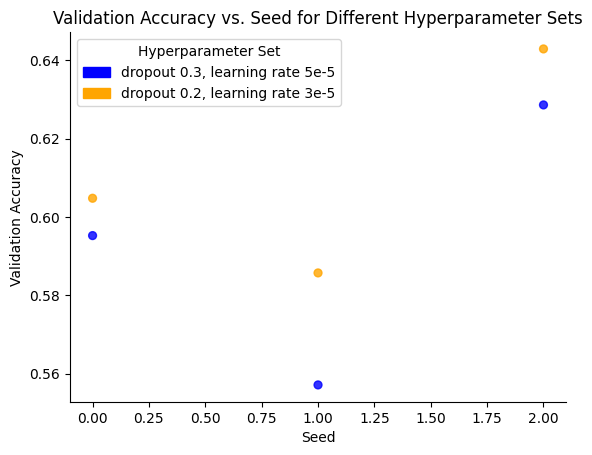

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Add a new column to classify parameter sets
results2_df['parameter_set'] = results2_df.apply(
    lambda row: 'Set 1' if row['dropout'] == 0.3 and row['learning_rate'] == 5e-5 else 'Set 2',
    axis=1
)

# Create a scatter plot with 'seed' on the x-axis and 'val_accuracy' on the y-axis
ax = results2_df.plot(kind='scatter', x='seed', y='val_accuracy', s=32, alpha=0.8,
                      c=results2_df['parameter_set'].map({'Set 1': 'blue', 'Set 2': 'orange'}))

# Remove the top and right spines for a cleaner plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Add title and labels
plt.title('Validation Accuracy vs. Seed for Different Hyperparameter Sets')
plt.xlabel('Seed')
plt.ylabel('Validation Accuracy')

# Manually add the legend with custom labels and colors
# Create custom legend entries for the two hyperparameter sets
set1_patch = mpatches.Patch(color='blue', label='dropout 0.3, learning rate 5e-5')
set2_patch = mpatches.Patch(color='orange', label='dropout 0.2, learning rate 3e-5')

# Add the custom legend to the plot
plt.legend(handles=[set1_patch, set2_patch], title='Hyperparameter Set')

# Display the plot
plt.show()


In [ ]:
# Group by hyperparameters
average_results = results2_df.groupby(['dropout', 'learning_rate', 'pooler'])['val_accuracy'].mean().reset_index()

# Print the average results
average_results

,dropout,learning_rate,pooler,val_accuracy
0,0.2,0.00003,False,0.611111
1,0.3,0.00005,False,0.593651


Looks like the best hyperparameters are:

**dropout 0.3, learning rate 5e-5, seed 2.**

## Epoch Tests

Just use early stopping and see. I did the ClimateBERT finetuning first and this as more illustrative.

**Answer: use two epochs.**

In [ ]:
# Early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = create_bert_multiclass_model(
        checkpoint=checkpoint,
        num_classes=3,
        hidden_size=201,
        dropout=0.3,
        learning_rate=5e-5,
        pooler=False
)

# Train model with the current number of epochs
history = model.fit(
        [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
        train_sentiment,
        validation_split=0.1,  # split 10% of data for validation
        batch_size=8,
        epochs=7,
        callbacks=[early_stopping]
)

NameError: name 'tf' is not defined

Seems like two epochs is best. I'm going to examine if there are any patterns with the validation errors and also integrate class_weights.

## Class Weights

**Answer: adjusted class_weights are best {0:0.90, 1:2.01388889, 2:0.73403427}.**

### Imports and CM Function

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into the first 90% for training and the last 10% for evaluation
split_index = int(0.9 * len(x_train['input_ids']))  # Use length of input_ids (same length for all keys)

# Create training and validation subsets
x_train_subset = {
    'input_ids': x_train['input_ids'][:split_index],
    'attention_mask': x_train['attention_mask'][:split_index],
    'token_type_ids': x_train['token_type_ids'][:split_index]
}

train_sentiment_subset = train_sentiment[:split_index]

x_val_subset = {
    'input_ids': x_train['input_ids'][split_index:],  # Last 10% for validation
    'attention_mask': x_train['attention_mask'][split_index:],
    'token_type_ids': x_train['token_type_ids'][split_index:]
}

y_val_subset = train_sentiment[split_index:]  # Validation labels

In [ ]:
# Function to make confusion matrices

def my_confusion_matrix(y_val_subset, predictions_class):
    # Generate the confusion matrix
    cm = confusion_matrix(y_val_subset, predictions_class)

    # Create a new figure and plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2],
                ax=ax, vmin=0, vmax=80)

    # Add labels and title
    ax.set_title("Confusion Matrix Heatmap")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

    # Close the plot automatically to avoid double rendering in notebooks
    plt.close(fig)

    return fig

### Test Inverse Class Weights


| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.53      | 0.89   | 0.67     | 71      |
| 1     | 0.58      | 0.37   | 0.45     | 49      |
| 2     | 0.85      | 0.58   | 0.69     | 90      |
| **Accuracy**  |           |        | 0.63     | 210     |
| **Macro Avg** | 0.66      | 0.61   | 0.60     | 210     |
| **Weighted Avg** | 0.68  | 0.63   | 0.63     | 210     |


In [ ]:
class_weights = {0: 2.63, 1: 5.74, 2: 2.25}  # Inverse frequency counts

# Create the model
model = create_bert_multiclass_model(
    checkpoint=checkpoint,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=5e-5,
    pooler=False
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['token_type_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=2,
    class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/2


236/236 [==============================] - 153s 491ms/step - loss: 2.8901 - accuracy: 0.5538 - val_loss: 1.1231 - val_accuracy: 0.4714
Epoch 2/2
7/7 [==============================] - 7s 579ms/step
              precision    recall  f1-score   support

           0       0.53      0.89      0.67        71
           1       0.58      0.37      0.45        49
           2       0.85      0.58      0.69        90

    accuracy                           0.63       210
   macro avg       0.66      0.61      0.60       210
weighted avg       0.68      0.63      0.63       210



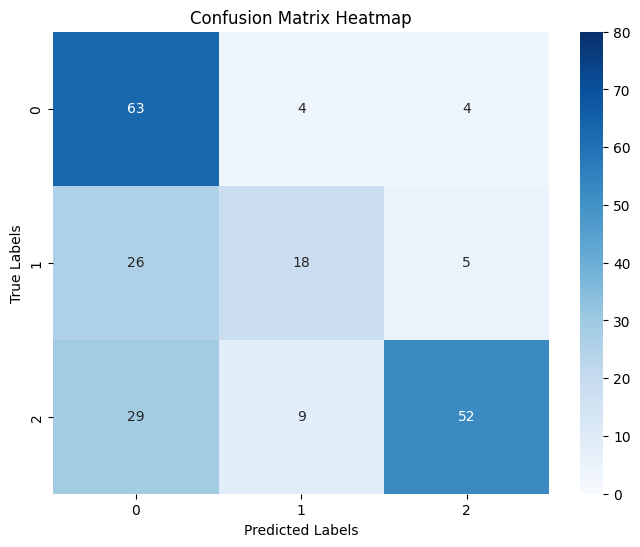

In [ ]:
cm1 = my_confusion_matrix(y_val_subset, predictions_class)
cm1

This is looking good! Let me see what it looks like without class weights for comparison.

### No Class Weights Baseline

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.53      | 0.89   | 0.66     | 71      |
| 1     | 0.86      | 0.37   | 0.51     | 49      |
| 2     | 0.83      | 0.64   | 0.72     | 90      |
| **Accuracy**  |           |        | 0.66     | 210     |
| **Macro Avg** | 0.74      | 0.63   | 0.63     | 210     |
| **Weighted Avg** | 0.73  | 0.66   | 0.65     | 210     |

In [ ]:
#class_weights = {0: 2.63, 1: 5.74, 2: 2.25}  # Inverse frequency counts

# Create the model
model = create_bert_multiclass_model(
    checkpoint=checkpoint,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=5e-5,
    pooler=False
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['token_type_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=2
    #class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']]
)

# If your model outputs logits, apply argmax to get the predicted class labels
predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))


/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/2


236/236 [==============================] - 156s 502ms/step - loss: 0.8548 - accuracy: 0.6324 - val_loss: 0.8097 - val_accuracy: 0.6000
Epoch 2/2
7/7 [==============================] - 7s 582ms/step
              precision    recall  f1-score   support

           0       0.53      0.89      0.66        71
           1       0.86      0.37      0.51        49
           2       0.83      0.64      0.72        90

    accuracy                           0.66       210
   macro avg       0.74      0.63      0.63       210
weighted avg       0.73      0.66      0.65       210



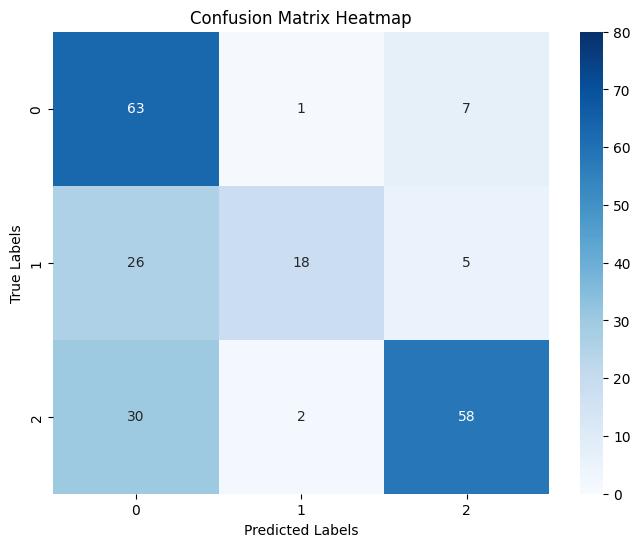

In [ ]:
cm2 = my_confusion_matrix(y_val_subset, predictions_class)
cm2

Doesn't look like the manually set weights were that good so now I want to try using compute_class_weight.

### Try Compute_Class_Weight

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.53      | 0.77   | 0.63     | 71      |
| 1     | 0.79      | 0.22   | 0.35     | 49      |
| 2     | 0.74      | 0.77   | 0.75     | 90      |
| **Accuracy**  |           |        | 0.64     | 210     |
| **Macro Avg** | 0.69      | 0.59   | 0.58     | 210     |
| **Weighted Avg** | 0.68  | 0.64   | 0.62     | 210     |

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert train_sentiment_subset to a numpy array if it's a tensor
train_sentiment_subset_np = train_sentiment_subset.numpy() if hasattr(train_sentiment_subset, 'numpy') else train_sentiment_subset

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Automatically computes weights inversely proportional to class frequencies
    classes=np.unique(train_sentiment_subset_np),  # Unique classes (0, 1, 2, etc.)
    y=train_sentiment_subset_np  # Target array of labels
)

# Convert the class weights into a dictionary (class -> weight)
class_weights = {i: class_weights_array[i] for i in np.unique(train_sentiment_subset_np)}

# Print the class weights to check
print("Computed Class Weights:", class_weights)

# Create the model
model = create_bert_multiclass_model(
    checkpoint=checkpoint,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=5e-5,
    pooler=False
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['token_type_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=2,
    class_weight=class_weights  # Pass the computed class weights here
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']]
)

# If your model outputs logits, apply argmax to get the predicted class labels
predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))

Computed Class Weights: {0: 0.8763365876336587, 1: 2.013888888888889, 2: 0.7340342679127726}


/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/2


236/236 [==============================] - 154s 500ms/step - loss: 0.9537 - accuracy: 0.5565 - val_loss: 0.9061 - val_accuracy: 0.5429
Epoch 2/2
7/7 [==============================] - 7s 578ms/step
              precision    recall  f1-score   support

           0       0.53      0.77      0.63        71
           1       0.79      0.22      0.35        49
           2       0.74      0.77      0.75        90

    accuracy                           0.64       210
   macro avg       0.69      0.59      0.58       210
weighted avg       0.68      0.64      0.62       210



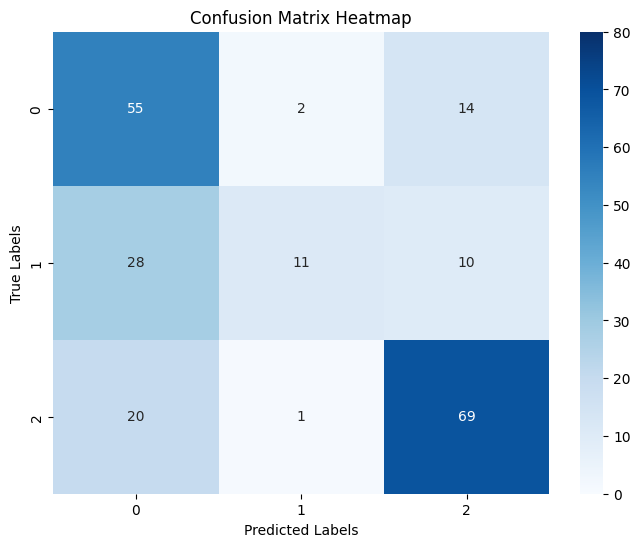

In [ ]:
cm3 = my_confusion_matrix(y_val_subset, predictions_class)
cm3

### Manually Adjust Compute_Class_Weight

It seems like the classes could use a little more balancing, as the classes with larger supports have higher F1 scores. I'm going to try to adjust 0 higher and see.

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.57      | 0.68   | 0.62     | 71      |
| 1     | 0.54      | 0.65   | 0.59     | 49      |
| 2     | 0.84      | 0.62   | 0.71     | 90      |
| **Accuracy**  |           |        | 0.65     | 210     |
| **Macro Avg** | 0.65      | 0.65   | 0.64     | 210     |
| **Weighted Avg** | 0.68  | 0.65   | 0.65     | 210     |

In [ ]:
class_weights = {0:0.90, 1:2.01388889, 2:0.73403427}  # adjusted class_weights from above

# Create the model
model = create_bert_multiclass_model(
    checkpoint=checkpoint,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=5e-5,
    pooler=False
)

# Train the model on the first 90% of the data
history = model.fit(
    [x_train_subset['input_ids'], x_train_subset['token_type_ids'], x_train_subset['attention_mask']],
    train_sentiment_subset,
    validation_data=(
        [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']],
        y_val_subset
    ),
    batch_size=8,
    epochs=2,
    class_weight=class_weights
)

# Evaluate on the last 10% of data
predictions = model.predict(
    [x_val_subset['input_ids'], x_val_subset['token_type_ids'], x_val_subset['attention_mask']]
)

# If your model outputs logits, apply argmax to get the predicted class labels
predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(y_val_subset, predictions_class))


/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/2


236/236 [==============================] - 155s 501ms/step - loss: 0.9818 - accuracy: 0.5279 - val_loss: 0.8282 - val_accuracy: 0.6048
Epoch 2/2
7/7 [==============================] - 7s 577ms/step
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        71
           1       0.54      0.65      0.59        49
           2       0.84      0.62      0.71        90

    accuracy                           0.65       210
   macro avg       0.65      0.65      0.64       210
weighted avg       0.68      0.65      0.65       210



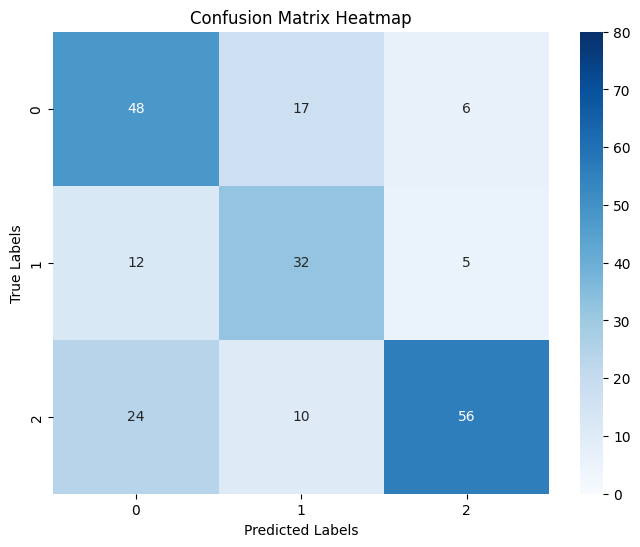

In [ ]:
cm4 = my_confusion_matrix(y_val_subset, predictions_class)
cm4

### Confusion Matrix Results

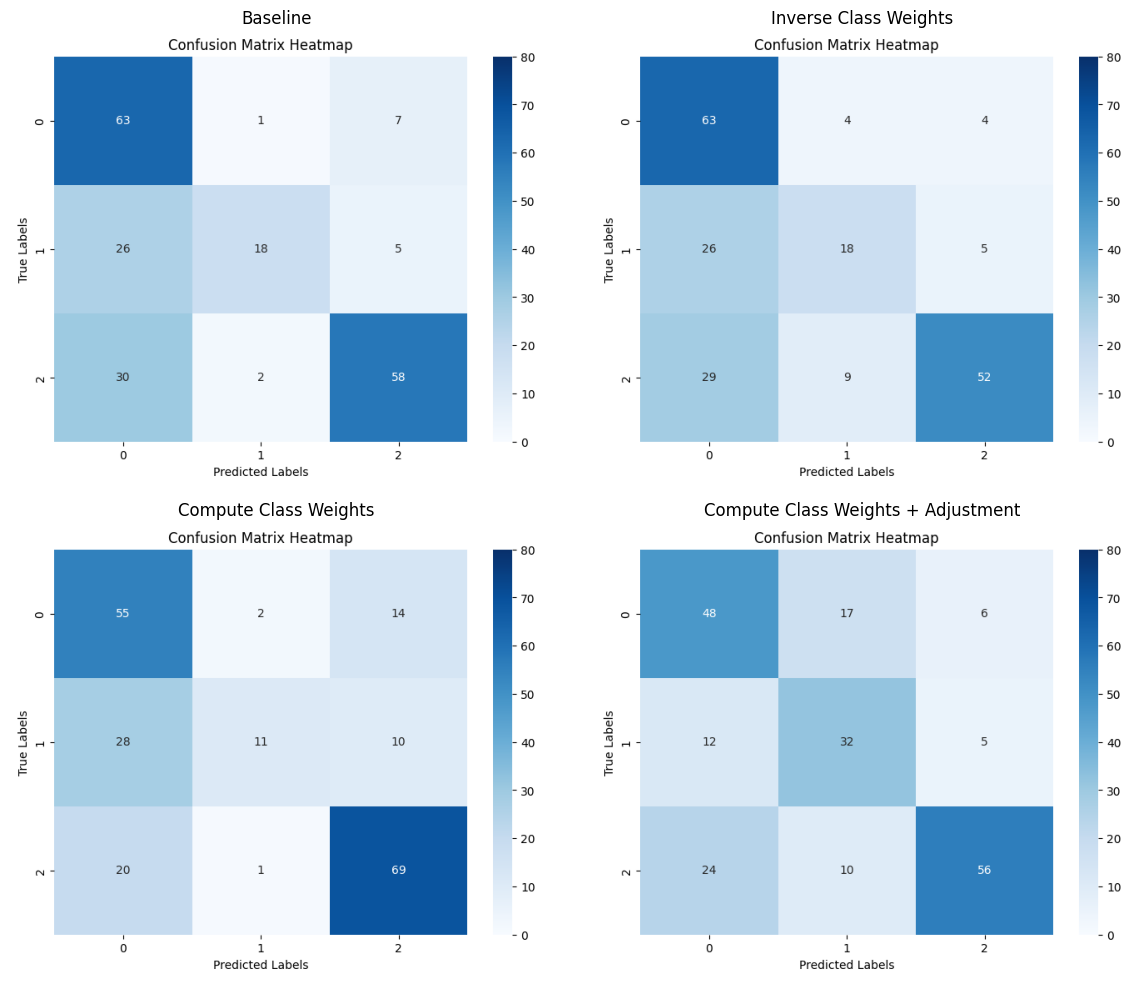

In [ ]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Display each confusion matrix in the grid
axes[0, 0].imshow(cm2.canvas.buffer_rgba())
axes[0, 1].imshow(cm1.canvas.buffer_rgba())
axes[1, 0].imshow(cm3.canvas.buffer_rgba())
axes[1, 1].imshow(cm4.canvas.buffer_rgba())

# Add titles for each subplot
axes[0, 0].set_title("Baseline")
axes[0, 1].set_title("Inverse Class Weights")
axes[1, 0].set_title("Compute Class Weights")
axes[1, 1].set_title("Compute Class Weights + Adjustment")

# Remove axes and ticks for each subplot
for ax in axes.flat:
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the grid with confusion matrices
plt.show()


### Conclusion

The proportions are mostly even between train and validation. However, there are far fewer disagrees and that is also the class that is doing the worst. This makes me inclined to pick compute_class_weights + adjustment, as it did better at classifying 1s than any other program.



| Label         | Val Count | Train Count | Val Prop | Train Prop |
|---------------|-----------|-------------|----------|------------|
| 0 (Neutral)   | 71        | 717         | 0.338    | 0.380      |
| 1 (Disagree)  | 49        | 312         | 0.233    | 0.166      |
| 2 (Agree)     | 90        | 856         | 0.429    | 0.454      |

## Final Specifications

* Dropout 0.3
* Learning Rate 5e-5
* Seed 2
* Epochs 2
* Pooler False
* Class Weights {0:0.90, 1:2.01388889, 2:0.73403427}

# Test Results

In [ ]:
class_weights = {0: 0.90, 1: 2.01388889, 2: 0.73403427}

# Set Random Seeds
np.random.seed(2)
tf.random.set_seed(2)

# Create the model
test_model = create_bert_multiclass_model(
    checkpoint=checkpoint,
    num_classes=3,
    hidden_size=201,
    dropout=0.3,
    learning_rate=5e-5,
    pooler=False
)

# Train the model on the first 90% of the data
history = test_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    train_sentiment,
    validation_split=0.1,
    batch_size=8,
    epochs=2,
    class_weight=class_weights
)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_pytorch_utils.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_state_dict = torch.load(pt_path, map_

Epoch 1/2


236/236 [==============================] - 154s 499ms/step - loss: 0.9270 - accuracy: 0.5714 - val_loss: 0.8050 - val_accuracy: 0.6333
Epoch 2/2
236/236 [==============================] - 116s 492ms/step - loss: 0.5438 - accuracy: 0.7899 - val_loss: 0.8435 - val_accuracy: 0.6190


7/7 [==============================] - 4s 585ms/step
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        85
           1       0.47      0.87      0.61        39
           2       0.81      0.38      0.52        76

    accuracy                           0.62       200
   macro avg       0.65      0.66      0.61       200
weighted avg       0.68      0.62      0.61       200



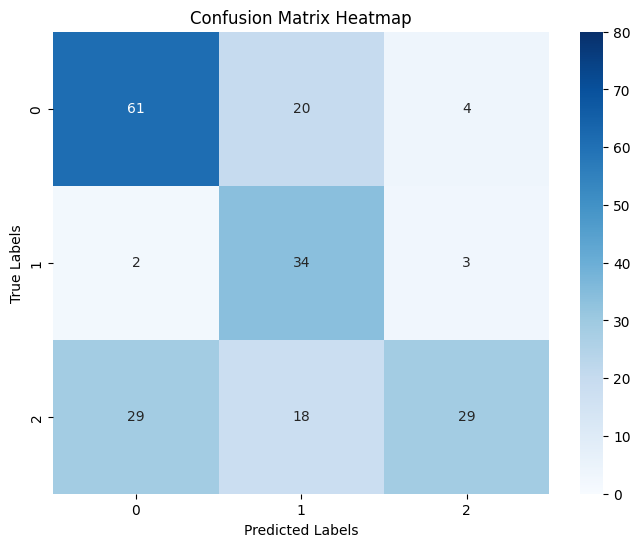

In [ ]:
# Evaluate on the test data
predictions = test_model.predict(
    [x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]
)

predictions_class = predictions.argmax(axis=-1)

# Generate the classification report
print(classification_report(test_sentiment, predictions_class))

cm_test = my_confusion_matrix(test_sentiment, predictions_class)
cm_test

In [ ]:
print(predictions_class)
df_predictions = pd.DataFrame(predictions_class, columns=['Predictions'])
df_predictions.to_csv('/content/drive/MyDrive/w266/Final Project/meral_results/BERT_test_results.csv', index=False)

[1 0 2 1 0 1 1 1 0 1 2 1 1 0 0 0 0 0 2 1 0 2 2 0 2 1 0 1 2 0 1 0 0 0 1 1 2
 2 0 2 0 0 0 0 0 1 2 1 0 1 2 1 0 0 0 2 2 0 0 1 0 2 0 1 2 2 1 0 1 1 1 1 1 2
 1 1 0 0 0 0 2 0 2 1 0 0 1 1 1 0 0 0 1 0 2 1 0 0 0 1 1 1 2 2 0 0 0 1 0 0 1
 2 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 2 0 1 0 0 2 0 1 0 1 0 0 1 1 0 0 0 0 2 1
 1 1 1 0 0 0 1 1 2 2 0 1 0 1 1 0 2 0 1 0 0 1 0 2 0 2 1 1 2 0 0 1 0 0 1 0 1
 2 1 2 1 0 0 0 0 0 0 2 1 1 0 0]


In [ ]:
# export test data for analysis
test_sentiment_np = test_sentiment.numpy()  # shape: (3,)
test_data = pd.DataFrame({
    'Sentence': test_sentences,
    'Sentiment': test_sentiment_np
})
test_data.to_csv('/content/drive/MyDrive/w266/Final Project/test_data.csv', index=False)